# Inference U-NET Models for lung thickness estimation

Inference U-NET Models for lung thickness estimation

@author M. Schultheiss

Make sure to install the required packages before:
```
pip3 install tensorflow --user --upgrade
pip3 install keras --user --upgrade
```

You need to provide a test.dcm radiograph file in the same directory!

### First, packages are imported:

In [ ]:
import numpy as np
import sys
from skimage import exposure
import numpy as np
import pydicom
import os
import keras
import skimage
import tensorflow as tf
from keras.models import load_model
from keras.utils.generic_utils import get_custom_objects
import keras.backend as K
from skimage.measure import label, regionprops
from skimage.morphology import convex_hull_image
import matplotlib.pyplot as plt
 
#  Run on cpu, not gpu
os.environ["CUDA_VISIBLE_DEVICES"] = ""

### Next we define the loss functions and load the model

In [ ]:
def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    smooth = K.constant(1e-6)
    intersect = K.sum(y_pred_f * y_true_f)
    denom = K.sum(y_pred_f) + K.sum(y_true_f)
    score = K.constant(2) * intersect / (denom + smooth)
    return 1 - score

def depth_loss_function(y_true, y_pred, theta=2.0, maxDepthVal=250):
    """
	Depth loss for lung thickness estimation
	Based on the paper/code of https://arxiv.org/abs/1812.11941 and https://github.com/ialhashim/DenseDepth
        but heavily modified: For lung thickness estimation an extrathoratic term was added and SSIM loss was disabled. Furthermore MAE is multiplied with lung thickness during training process 
    """
    # Loss on lung pixels
    l_depth = K.mean(K.abs(y_pred - y_true) * ((y_true)), axis=-1)

    # Loss outside lung pixels
    l_outside = K.mean(K.abs(y_pred - y_true) * K.cast((y_true==0), K.floatx())*10, axis=-1)

    # Gradient loss
    dy_true, dx_true = tf.image.image_gradients(y_true) 
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

    # Optional: Structural similarity (SSIM) index loss (disabled in our lung thickness project)
    l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, maxDepthVal)) * 0.5, 0, 1)

    # Weights
    w_ssim = 0 # disable ssim
    w_grad = 1.0 
    w_depth = theta
    w_ext = 1.0
    return (w_ssim * l_ssim) + (w_grad * K.mean(l_edges)) + (w_depth * K.mean(l_depth)) + w_ext*K.mean(l_outside)


keras.losses.dice_loss = dice_loss
keras.metrics.dice_loss = dice_loss

try:
    get_custom_objects().update({"dice_loss": dice_loss})
    get_custom_objects().update({"depth_loss_function": depth_loss_function})

except:
    print("You should think about updating keras...")


### Preprocessing Code

In [ ]:
from skimage import exposure
import h5py
from skimage.transform import resize


def histogram_equalize(img):
    """
        Histogram Equalization required for lung segmentation
    """
    img_cdf, bin_centers = exposure.cumulative_distribution(img)
    return np.interp(img, bin_centers, img_cdf)

def crop_equal_size(inputimage):
    """
        Will crop the image to an equal size, e.g.  will make a 400 x 400 from a 410 x 410 image etc.
    """
    y,x = inputimage.shape
    
    if y<x:
        starty = 0
        width = y
        startx = (x-y)//2
        
    else:
        startx = 0
        width = x
        starty = (y-x)//2

    return inputimage[starty:starty+width,startx:startx+width]



def load_and_preprocess_dcm(filepath):
    """
        This function can be used to load DICOM files
    """
    if filepath.endswith(".dcm"):
        dcm = pydicom.dcmread(filepath)
        img = dcm.pixel_array

    assert(float(dcm.PixelSpacing[0])==float(dcm.PixelSpacing[1]))
    img = resize(img,[256,256],preserve_range = True)
    
    factor_x = float(dcm.Rows)/256.
    factor_y = float(dcm.Columns)/256.

    
    img = img.astype('float32')
    #img = histogram_equalize(img)

    #  Normalization

    img = img/img.max()

    img = crop_equal_size(img)
    
    img = img.transpose(1,0)

    newspacing = str(factor_x*float(dcm.PixelSpacing[0])) + ","+ str(factor_y*float(dcm.PixelSpacing[1]))
    return img, newspacing

def scaledown_and_normalize(img, pixelspacing):
    """
        pixelspacing must be a tuple, e.g. (0.15,0.15)
    """

    img = crop_equal_size(img)

    
    factor_x = img.shape[0]/256.
    factor_y = img.shape[1]/256.
    
    img = resize(img,[256,256],preserve_range = True)
    img = img.astype('float32')
    
    newspacing = str(factor_x*float(pixelspacing[0])) + ","+ str(factor_y*float(pixelspacing[1]))


    img = img/img.max()

    img = img.transpose(1,0)
    
    
    return img, newspacing

def load_hdf_radiography(filepath):
    """
        This function can be used to load a HDF5 file
    """
    with h5py.File(filepath, "r") as h5file:
        if "radiograph" in h5file.keys():
            radiograph = np.array(h5file["radiograph"]).squeeze()

            pixelspacing = str(h5file["radiograph"].attrs["PixelSpacing"])
            try:
                pixelspacing= pixelspacing.decode("utf-8")
            except:
                pass
 
            return scaledown_and_normalize(radiograph, (float(pixelspacing.split(",")[0]),  float(pixelspacing.split(",")[1])))


def curatelungmask(lungmask):
    """
        Remove small parts
    """
    label_image = label(lungmask)
    result = np.zeros_like(lungmask)

    for region in regionprops(label_image):

        if region.area > 4100: # Ignore small areas
            mask = label_image==region.label
            result+=mask
    return result


def better_mask(binary_segmentation):
    """
        Convex Hull. 
    """
    # Convex hull to include area between lung lobes
    return convex_hull_image(np.ascontiguousarray(binary_segmentation))




__Important__: input image should be rotated by 90 degrees, e.g. it should appear like this in the following code block. 

Otherwise the prediction will not work!!

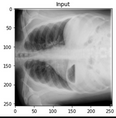

In [ ]:
def load_file(filepath):
    """
        Loads either a dicom file or a HDF5 file
        
        Args:
            filepath: Should end with .dcm for DICOM files and with .h5 for HDF5 files.
    """
    if filepath.endswith(".h5"):
         img, spacing = load_hdf_radiography(filepath)
    else:
        img, spacing = load_and_preprocess_dcm(filepath)
        
    return img, spacing

img, spacing = load_file("test.dcm")



plt.figure()
plt.title("Input")
plt.imshow(img, cmap="gray")


In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt

modelpath = "model_v3.h5"
unet_lungseg = load_model("model_lungseg.h5")

print("Prediction Model was created on ", datetime.utcfromtimestamp(int(os.path.getmtime(modelpath))).strftime('%Y-%m-%d %H:%M:%S') )
print("Lung Segmentation Model was created on ", datetime.utcfromtimestamp(int(os.path.getmtime(modelpath))).strftime('%Y-%m-%d %H:%M:%S') )

In [ ]:
def get_volume_from_projection_real_radiograph(projection_image, pixelsize):
    """
        Get volume from projection give a certain geometry.
        Adapt magnification to your setup.
    """
    #assert(projection_image.shape[0] == 512)
    OD_dist = 120.0 
    SO_dist =1680.0

    SD_Dist = SO_dist+OD_dist
    Magnification = SO_dist/SD_Dist # < 1

    return (((projection_image.sum()) * (pixelsize  * Magnification ) * (pixelsize * Magnification    ))) * 1e-06  # do not mulltyply by mm3 but by mm2 in the nd as thickness is already one dimeinson



In [ ]:
def predict_file(filepath):
    """
        Predicts either a dicom file or a HDF5 file
        
        Args:
            filepath: Should end with .dcm for DICOM files and with .h5 for HDF5 files.
    """
    img, spacing = load_file(filepath)
    # print("Image sum is", img.mean()) # For debugging
    unet = load_model(modelpath)

    # Lung segmentation models input a transposed image!
    input_lungsegmentation =  img.copy()
    input_lungsegmentation /= input_lungsegmentation.max()
    input_lungsegmentation = histogram_equalize(input_lungsegmentation.transpose(1,0))
    input_lungsegmentation /= input_lungsegmentation.max()

    result = unet.predict(img[:,:,np.newaxis][np.newaxis,:,:,:]).squeeze()
    result_lungseg = unet_lungseg.predict(input_lungsegmentation[:,:,np.newaxis][np.newaxis,:,:,:]).squeeze().transpose(1,0)
    result_lungseg = curatelungmask(result_lungseg)

    plt.figure()
    plt.title("Input")
    plt.imshow(img.transpose(1,0), cmap="gray")
    plt.colorbar()
    plt.figure()
    plt.title("Thickness Map")

    thickness_map = (result*(result_lungseg>0.5)).squeeze()
    
    
    plt.imshow((result*better_mask(result_lungseg)).transpose(1,0))
    plt.colorbar()


    volume = get_volume_from_projection_real_radiograph(thickness_map, float(spacing.split(",")[0]))
    #volume = volume * 1e-06 # Convert mm^3 to dm^3

    print("Pixel Spacing is ",spacing, "mm")
    print("Volume is " + str(volume) + " liter")

    return thickness_map

In [ ]:
thicknessmap = predict_file("test.dcm")

In [ ]:
thicknessmap = predict_file("/path/to/hdf5")